25aug2025

Data preprocessing complete. Training data is now balanced and scaled.
------------------------------------------------------------
Starting hyperparameter tuning...
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Hyperparameter tuning complete.
------------------------------------------------------------
--- Final Ensemble Model Evaluation ---
Accuracy: 93.40%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       155
           1       0.82      0.96      0.89        57

    accuracy                           0.93       212
   macro avg       0.90      0.94      0.92       212
weighted avg       0.94      0.93      0.94       212


Confusion Matrix (Ensemble Model):


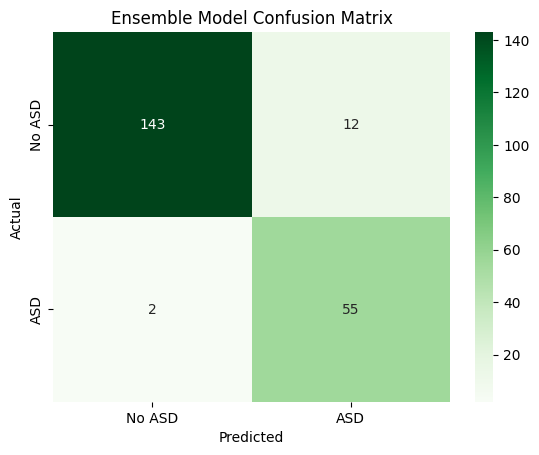

------------------------------------------------------------
Generating SHAP feature importance plot...


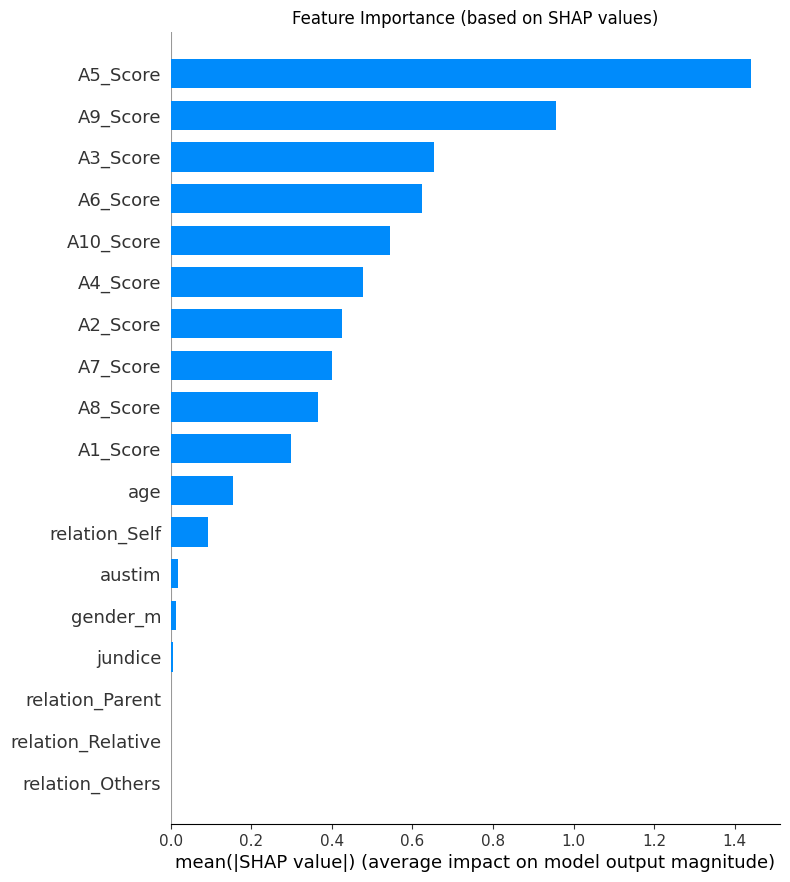

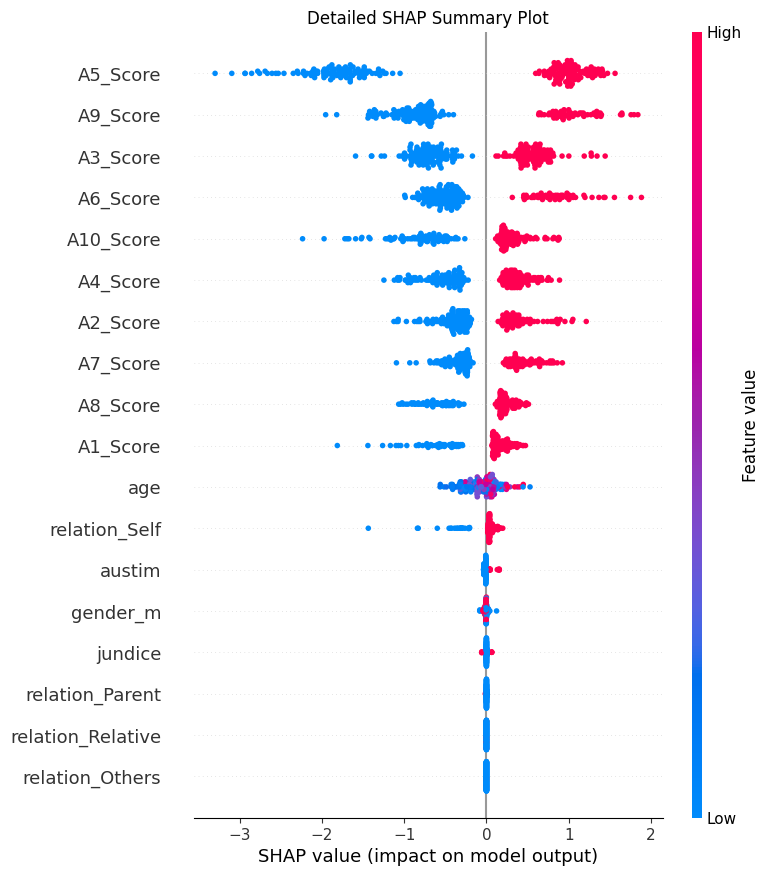

Analysis complete.


In [ ]:
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# Step 2: Load and Preprocess Data
# -----------------------------------------------------------------------------
url = 'https://raw.githubusercontent.com/karrtik18/BTP_ASD-/main/autism_dataset.csv'
df = pd.read_csv(url)

# Replace placeholders and impute missing values
df.replace('?', np.nan, inplace=True)
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age'].fillna(df['age'].median(), inplace=True)
for col in ['gender', 'jundice', 'austim', 'relation']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Feature Engineering
df.drop(['ethnicity', 'contry_of_res', 'age_desc', 'used_app_before', 'result'], axis=1, inplace=True)
binary_map = {'yes': 1, 'no': 0, 'YES': 1, 'NO': 0}
for col in ['jundice', 'austim', 'Class/ASD']:
    df[col] = df[col].map(binary_map)
df = pd.get_dummies(df, columns=['gender', 'relation'], drop_first=True)

# -----------------------------------------------------------------------------
# Step 3: Prepare Data for Modeling
# -----------------------------------------------------------------------------
X = df.drop('Class/ASD', axis=1)
y = df['Class/ASD']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance (on training data ONLY)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features for models like SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete. Training data is now balanced and scaled.")
print("-" * 60)

# -----------------------------------------------------------------------------
# Step 4: Hyperparameter Tuning with GridSearchCV
# -----------------------------------------------------------------------------
# Define parameter grids for each model
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Create a dictionary of models and their parameter grids
models_to_tune = {
    "XGBoost": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb),
    "SVM": (SVC(probability=True, random_state=42), param_grid_svc),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_rf)
}

best_estimators = {}

print("Starting hyperparameter tuning...")
for name, (model, params) in models_to_tune.items():
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='accuracy', verbose=0)
    grid_search.fit(X_train_scaled, y_train_resampled)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

print("Hyperparameter tuning complete.")
print("-" * 60)

# -----------------------------------------------------------------------------
# Step 5: Build and Evaluate the Ensemble Model
# -----------------------------------------------------------------------------
# Use the best estimators found from GridSearchCV
xgb_best = best_estimators['XGBoost']
svc_best = best_estimators['SVM']
rf_best = best_estimators['Random Forest']

# Create the Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb_best), ('svc', svc_best), ('rf', rf_best)],
    voting='soft' # 'soft' uses predicted probabilities, often performs better
)

# Fit the ensemble model
ensemble_model.fit(X_train_scaled, y_train_resampled)

# Make predictions and evaluate
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

print("--- Final Ensemble Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble) * 100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

# Visualize the Confusion Matrix
print("\nConfusion Matrix (Ensemble Model):")
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No ASD', 'ASD'], yticklabels=['No ASD', 'ASD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Model Confusion Matrix')
plt.show()
print("-" * 60)

# -----------------------------------------------------------------------------
# Step 6: Model Interpretability with SHAP
# -----------------------------------------------------------------------------
# SHAP works well with tree-based models like XGBoost.
# Let's explain the predictions of our optimized XGBoost model.
print("Generating SHAP feature importance plot...")

# Create the SHAP explainer
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test_scaled)

# Convert scaled test data back to DataFrame for better feature names
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Create the summary plot (bar chart)
# This plot shows the most important features
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title("Feature Importance (based on SHAP values)")
plt.show()

# Create a detailed summary plot (beeswarm)
# This shows the impact of each feature on the model's output
shap.summary_plot(shap_values, X_test_df, show=False)
plt.title("Detailed SHAP Summary Plot")
plt.show()
print("Analysis complete.")

Data preprocessing complete. Training data is now balanced and scaled.
------------------------------------------------------------
Starting hyperparameter tuning...
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Hyperparameter tuning complete.
------------------------------------------------------------
--- Final Ensemble Model Evaluation ---
Accuracy: 93.40%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       155
           1       0.82      0.96      0.89        57

    accuracy                           0.93       212
   macro avg       0.90      0.94      0.92       212
weighted avg       0.94      0.93      0.94       212


Confusion Matrix (Ensemble Model):


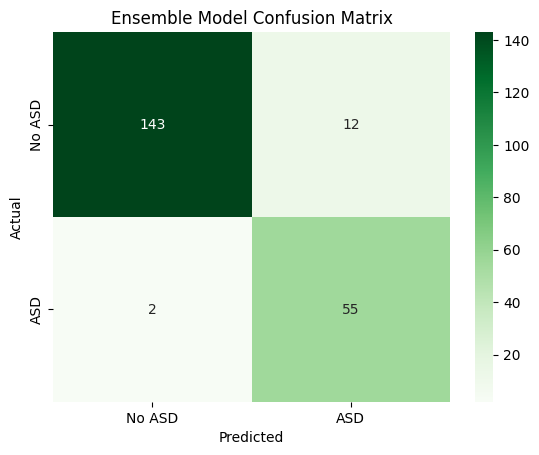

------------------------------------------------------------
Generating SHAP feature importance plot...


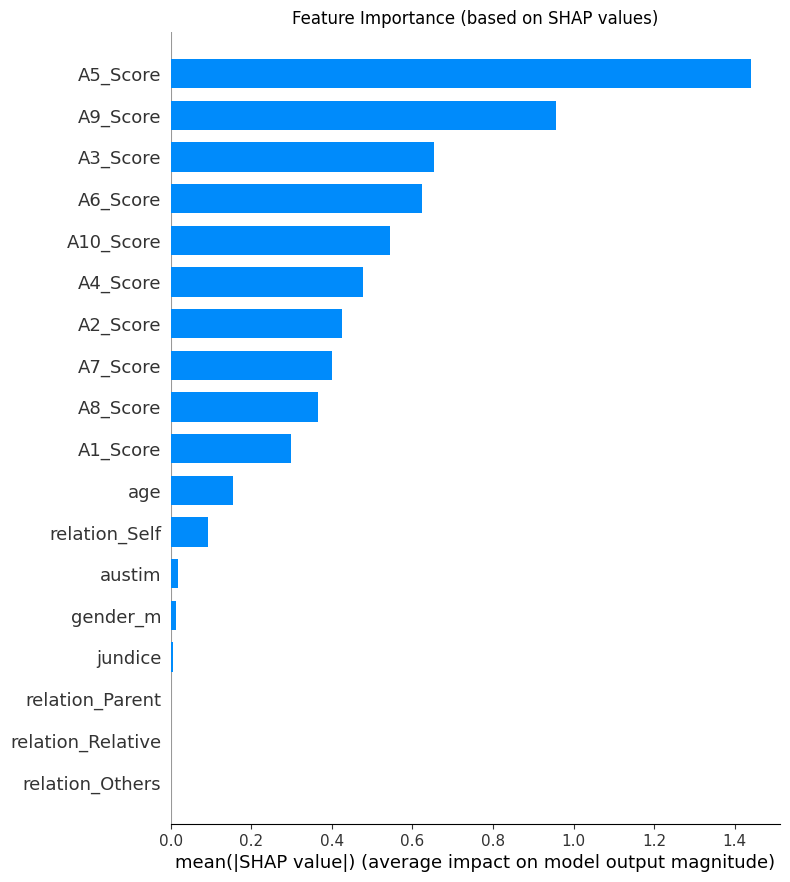

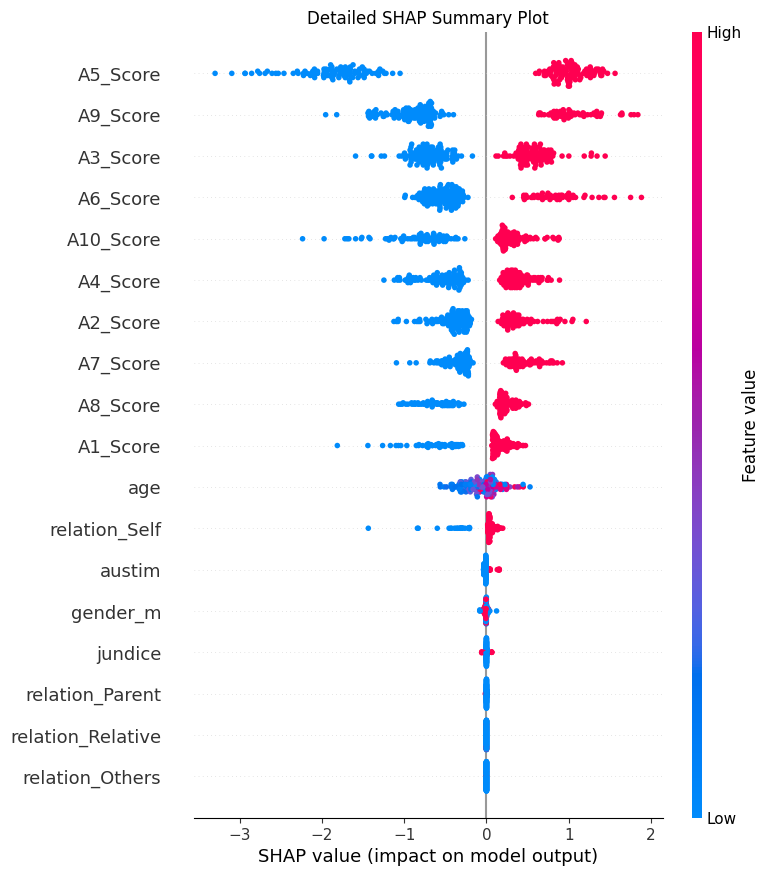

Analysis complete.
Generating ROC Curve comparison plot...
ROC plot saved as roc_curves.png


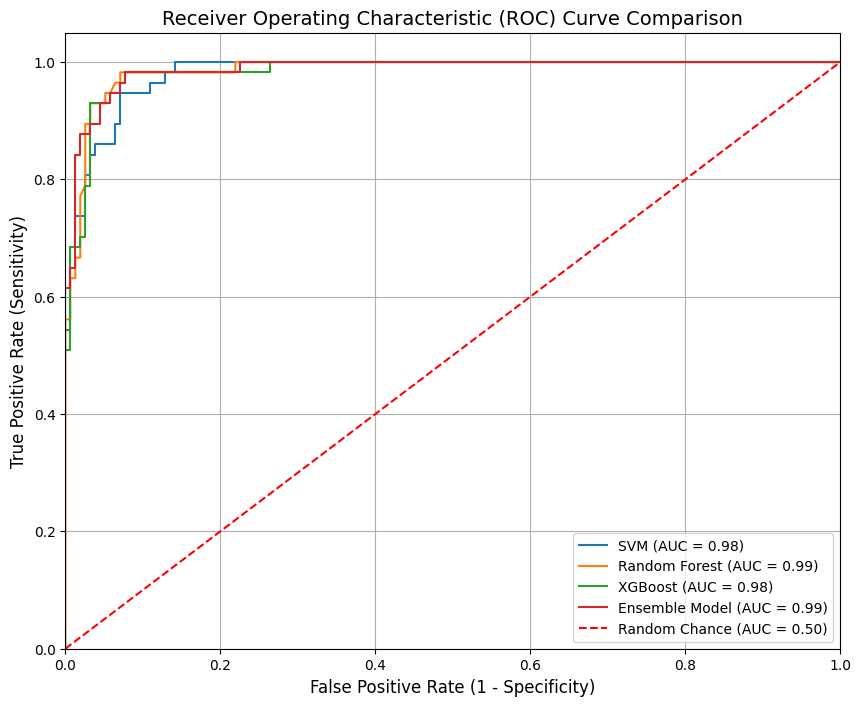

In [ ]:
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# Step 2: Load and Preprocess Data
# -----------------------------------------------------------------------------
url = 'https://raw.githubusercontent.com/karrtik18/BTP_ASD-/main/autism_dataset.csv'
df = pd.read_csv(url)

# Replace placeholders and impute missing values
df.replace('?', np.nan, inplace=True)
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age'].fillna(df['age'].median(), inplace=True)
for col in ['gender', 'jundice', 'austim', 'relation']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Feature Engineering
df.drop(['ethnicity', 'contry_of_res', 'age_desc', 'used_app_before', 'result'], axis=1, inplace=True)
binary_map = {'yes': 1, 'no': 0, 'YES': 1, 'NO': 0}
for col in ['jundice', 'austim', 'Class/ASD']:
    df[col] = df[col].map(binary_map)
df = pd.get_dummies(df, columns=['gender', 'relation'], drop_first=True)

# -----------------------------------------------------------------------------
# Step 3: Prepare Data for Modeling
# -----------------------------------------------------------------------------
X = df.drop('Class/ASD', axis=1)
y = df['Class/ASD']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance (on training data ONLY)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features for models like SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete. Training data is now balanced and scaled.")
print("-" * 60)

# -----------------------------------------------------------------------------
# Step 4: Hyperparameter Tuning with GridSearchCV
# -----------------------------------------------------------------------------
# Define parameter grids for each model
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Create a dictionary of models and their parameter grids
models_to_tune = {
    "XGBoost": (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb),
    "SVM": (SVC(probability=True, random_state=42), param_grid_svc),
    "Random Forest": (RandomForestClassifier(random_state=42), param_grid_rf)
}

best_estimators = {}

print("Starting hyperparameter tuning...")
for name, (model, params) in models_to_tune.items():
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='accuracy', verbose=0)
    grid_search.fit(X_train_scaled, y_train_resampled)
    best_estimators[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

print("Hyperparameter tuning complete.")
print("-" * 60)

# -----------------------------------------------------------------------------
# Step 5: Build and Evaluate the Ensemble Model
# -----------------------------------------------------------------------------
# Use the best estimators found from GridSearchCV
xgb_best = best_estimators['XGBoost']
svc_best = best_estimators['SVM']
rf_best = best_estimators['Random Forest']

# Create the Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb_best), ('svc', svc_best), ('rf', rf_best)],
    voting='soft' # 'soft' uses predicted probabilities, often performs better
)

# Fit the ensemble model
ensemble_model.fit(X_train_scaled, y_train_resampled)

# Make predictions and evaluate
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

print("--- Final Ensemble Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble) * 100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

# Visualize the Confusion Matrix
print("\nConfusion Matrix (Ensemble Model):")
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No ASD', 'ASD'], yticklabels=['No ASD', 'ASD'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Model Confusion Matrix')
plt.show()
print("-" * 60)

# -----------------------------------------------------------------------------
# Step 6: Model Interpretability with SHAP
# -----------------------------------------------------------------------------
# SHAP works well with tree-based models like XGBoost.
# Let's explain the predictions of our optimized XGBoost model.
print("Generating SHAP feature importance plot...")

# Create the SHAP explainer
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test_scaled)

# Convert scaled test data back to DataFrame for better feature names
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Create the summary plot (bar chart)
# This plot shows the most important features
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title("Feature Importance (based on SHAP values)")
plt.show()

# Create a detailed summary plot (beeswarm)
# This shows the impact of each feature on the model's output
shap.summary_plot(shap_values, X_test_df, show=False)
plt.title("Detailed SHAP Summary Plot")
plt.show()
print("Analysis complete.")

# -----------------------------------------------------------------------------
# Step 7: Generate and Save ROC Curve Comparison Plot
# -----------------------------------------------------------------------------
print("Generating ROC Curve comparison plot...")

# --- Create a dictionary of our final, trained models ---
# Note: SVM needs probability=True during initialization to use predict_proba
models_for_roc = {
    "SVM": svc_best,
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "Ensemble Model": ensemble_model
}

# --- Setup the plot ---
plt.figure(figsize=(10, 8))

# --- Iterate through models to plot their ROC curves ---
for name, model in models_for_roc.items():
    # Get prediction probabilities for the positive class (ASD)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Calculate Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# --- Plotting the baseline (random chance) line ---
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance (AUC = 0.50)')

# --- Final plot styling ---
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)

# --- Save the figure to a file for your report ---
plt.savefig('roc_curves.png', dpi=300)
print("ROC plot saved as roc_curves.png")
plt.show()